# Predicting property destruction caused by high severity wildfires in California

#### Joshua Clark

<img src='./img/cedar_fire.png' width="100%">

## 1. Background

From 2005 to 2020, wildland fires destroyed 59,987 structures in California (Headwaters Economics,
2020). Increasing human-caused fire activity coupled with longer duration critical weather conditions,
poor forest health, and the expansion of urban areas adjacent to wildlands have resulted in semi-annual
fire seasons that are only expected to worsen under future climate change scenarios (Clark et al., 2020),
yielding increasingly frequent “mega-fires” and urban conflagrations (i.e. wildfires that spread through
urban fuels such as structures). These largest and most complex types of wildland fires result in billions
of dollars of insured losses annually (the Camp Fire of 2018 resulted in $8.47 billion in losses alone
(Foley, 2018)), displace thousands of people from their homes and communities, and financially
devastate those that are underinsured.

In recent years, many efforts have been undertaken by the California Department of Forestry and Fire
Protection (CAL FIRE) prevention team to educate homeowners in fire-prone areas on construction
techniques and strategies to mitigate their wildfire risk. At the same time, the CAL FIRE investigation
team is spending more time following wildfires performing home damage assessments, increasing the
need for staff and cost to taxpayers. Developing a model from previous home damage assessment data
could help reduce time needed to perform future assessments (by assigning a preliminary likelihood of
damage rating to a home from prepopulated property characteristic data) and help the prevention team
educate homeowners on factors that reduce their home’s fire risk. Here, we consider 17,134 records of property-level wildfire damage assessments conducted by CAL FIRE from 2013 to 2020 to construct both a logistic regression and random forest classification model. 

## 2. Analysis

### 2.1 Data Processing

Library imports

In [78]:
import matplotlib.pyplot as plt  
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve, accuracy_score, precision_score, roc_auc_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_sample_weight
from tpot import TPOTClassifier
shap.initjs()

Data load

In [79]:
data = pd.read_csv("./data/CaliforniaFireDamage2013_2020_final.csv")
data.head(1)

,Damage,Structure_Type,Roof_Construction,Eaves,Vent_Screen,Exterior_Siding,Window_Pane,Deck_Porch_On_Grade,Deck_Porch_Elevated,Patio_Carport_Attached,...,Hydrants_within_1000ft,Fire_Stations_within_5mi,Elevation,Aspect,Slope,Year_Built,Latitude,Longitude,Incident_Name,Incident_Start_Date
0,Destroyed (>50%),Single Family Residence,Class A Standalone Asphalt Clay Concrete Tile ...,No Eaves or Enclosed,Mesh Screen Small Openings,Combustible or Wood,Multi Pane,Combustible Wood or Composite,No Deck/Porch or Concrete,No Patio Cover/Carport or Non Combustible,...,0,1,1173.1,South,10.57,0,39.059338,-122.578964,Pawnee,6/23/18


Encode damage amounts as binary classes where 0 means the property showed <50% damage (not destroyed) and 1 represents that the property was destroyed (>50% damage)

In [80]:
data["Damage"].replace({'No Damage': 0, 
                        'Affected (1-9%)': 0, 
                        'Minor (10-25%)': 0,
                        'Major (26-50%)': 0,
                        'Destroyed (>50%)': 1}, inplace=True)

data["Damage"].value_counts()

1    10617
0     5859
Name: Damage, dtype: int64

This data is unbalanced at a ~1.8:1 ratio so will use class weighting in model construction

One hot encode remaining categorical variables

In [81]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """ Given a particular dataframe and column name, one hot encodes the column """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

features_to_encode = ['Structure_Type', 
                      'Roof_Construction',
                      'Eaves',
                      'Vent_Screen',
                      'Exterior_Siding',
                      'Window_Pane',
                      'Deck_Porch_On_Grade',
                      'Deck_Porch_Elevated',
                      'Patio_Carport_Attached',
                      'Fence_Attached',
                      'Landcover_Type',
                      'Aspect']

for feature in features_to_encode:
    data = encode_and_bind(data, feature)

Log transform `Housing_Density` since urban and rural areas may have dramatically different values

In [82]:
with np.errstate(divide='ignore'):
    data["Housing_Density"] = np.where(data["Housing_Density"] > 0, np.log(data["Housing_Density"]), 0)

Create training and test dataset

In [83]:
y = data["Damage"]
X = data.drop(columns=['Damage', 
                       'Year_Built',  # Missing values unfortunately were set to 1900 or 0 in original data 
                       'Drought_Freq_Last_20yrs_Pct',  # Removed since all of these points are in high drought areas
                       'Latitude', 
                       'Longitude',
                       'Incident_Name',
                       'Incident_Start_Date'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, shuffle=True)

### 2.2 Logistic Regression

Initialize a logistic regression object. Here, `LogisticRegressionCV` is used to tune the hyperparameters for us. The training data is then fit to this model

In [84]:
lgrm = LogisticRegressionCV(solver='lbfgs', 
                            cv=10, 
                            max_iter=500,
                            random_state=7, 
                            class_weight='balanced', # Use balanced class weights
                            n_jobs=4, 
                            verbose=0).fit(X_train, y_train)

Perform 10-fold cross validation using stratified k-folds which preserve the percentage of samples for each class across the folds

In [85]:
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(lgrm, X_train, y_train, cv=kfold)

Display the model accuracy and confusion matrix for the initial fit

Mean accuracy across the folds is 82.01%


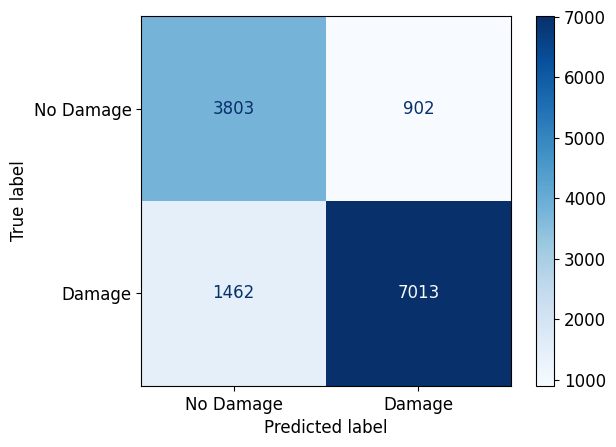

In [86]:
# Mean accuracy from CV and contingency table for training data
print(f"Mean accuracy across the folds is {np.round(np.mean(results) * 100, 2)}%")

# Confusion matrix
plot_confusion_matrix(lgrm, X_train, y_train, display_labels=["No Damage", "Damage"], cmap='Blues')  
plt.show()  

Evaluation of various classification thresholds on model. Examining the metrics below shows a good balance of performance around a threshold of 0.4 and 0.5. Will stick with the default classification threshold to maximize precision with minimal loss for accuracy 

In [87]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    preds = np.where(lgrm.predict_proba(X_test)[:,1] > i, 1, 0)

    model_metrics = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                       precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"])
    print(model_metrics)


******** For i = 0.1 ******
                      0
accuracy       0.741201
recall         0.975724
precision      0.722933
roc_auc_score  0.640808

******** For i = 0.2 ******
                      0
accuracy       0.788835
recall         0.946312
precision      0.777224
roc_auc_score  0.721423

******** For i = 0.3 ******
                      0
accuracy       0.817051
recall         0.911298
precision      0.825370
roc_auc_score  0.776706

******** For i = 0.4 ******
                      0
accuracy       0.827367
recall         0.880019
precision      0.857988
roc_auc_score  0.804827

******** For i = 0.5 ******
                      0
accuracy       0.825243
recall         0.838469
precision      0.886476
roc_auc_score  0.819581

******** For i = 0.6 ******
                      0
accuracy       0.805825
recall         0.776844
precision      0.911281
roc_auc_score  0.818231

******** For i = 0.7 ******
                      0
accuracy       0.758192
recall         0.675537
preci

Predict on 20% of data and report classification metrics

In [88]:
# Prediction and classification report
y_pred = lgrm.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(f"Model accuracy on test data is {np.round(cr['accuracy'] * 100, 2)}%")
print(f"Model weighted avg precision on test data is {np.round(cr['weighted avg']['precision'], 2)}")
print(f"Model weighted avg recall on test data is {np.round(cr['weighted avg']['recall'], 2)}")

Model accuracy on test data is 82.52%
Model weighted avg precision on test data is 0.83
Model weighted avg recall on test data is 0.83


Plot confusion matrix of test data

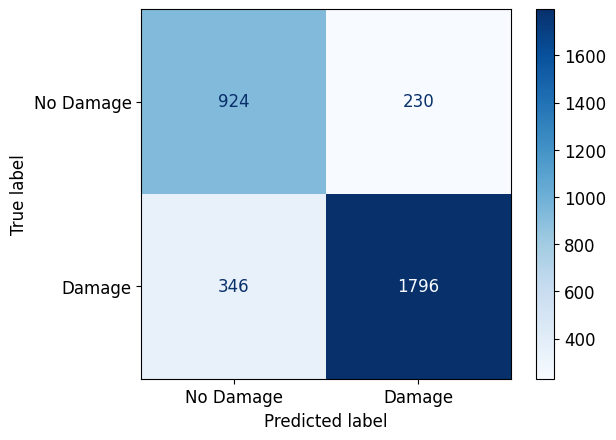

In [89]:
plot_confusion_matrix(lgrm, X_test, y_test, display_labels=["No Damage", "Damage"], cmap='Blues')  
plt.show()  

Plot ROC Curve

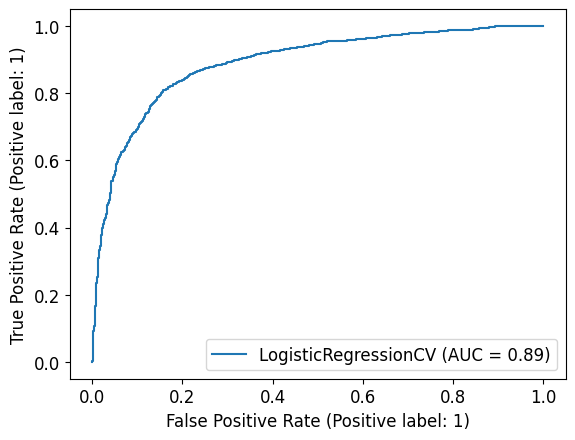

In [90]:
plot_roc_curve(lgrm, X_test, y_test)

Using SHAP to rank feature importance in the model (https://github.com/slundberg/shap) 

Mean feature importance

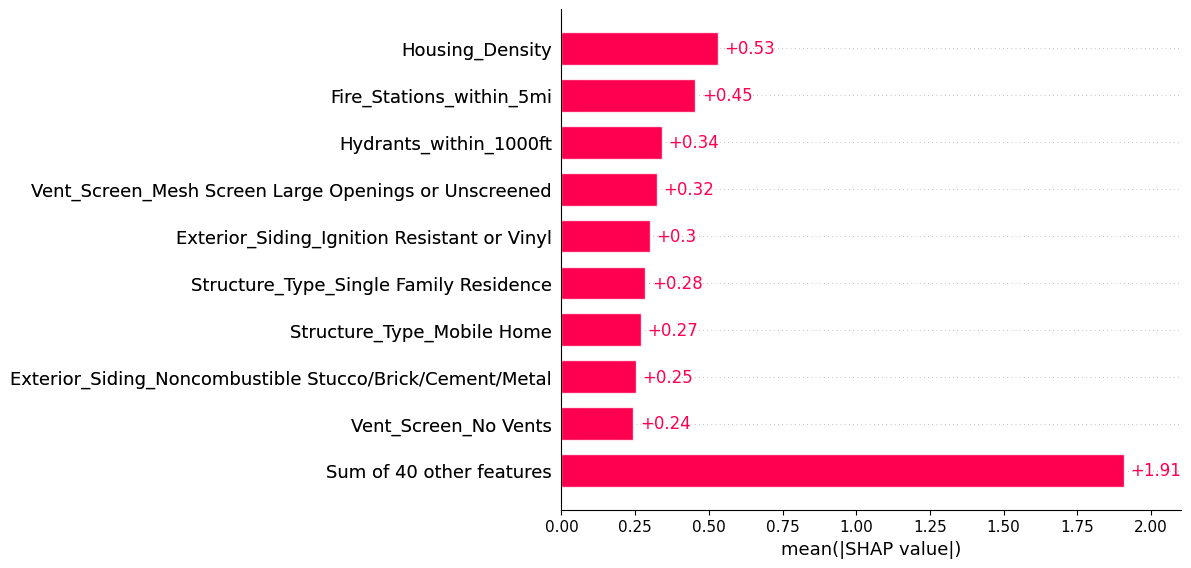

In [91]:
explainer = shap.LinearExplainer(lgrm, X_train)
shap_values = explainer(X_train)
shap.plots.bar(shap_values)

All feature importances

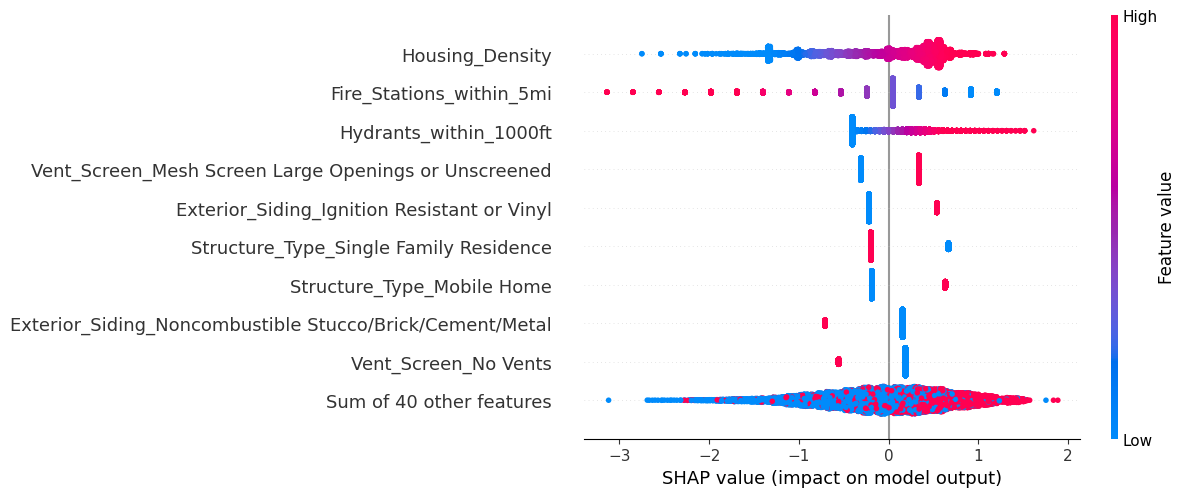

In [92]:
shap.plots.beeswarm(shap_values)

Breakdown of feature importances for two arbitrary records

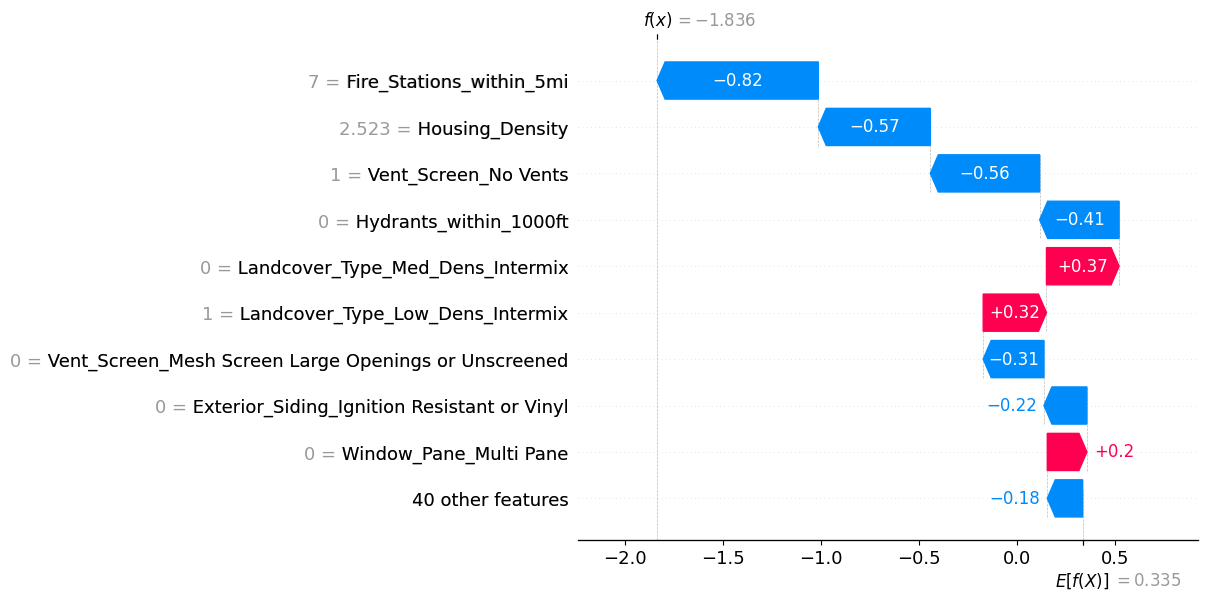

In [93]:
shap.plots.waterfall(shap_values[2])

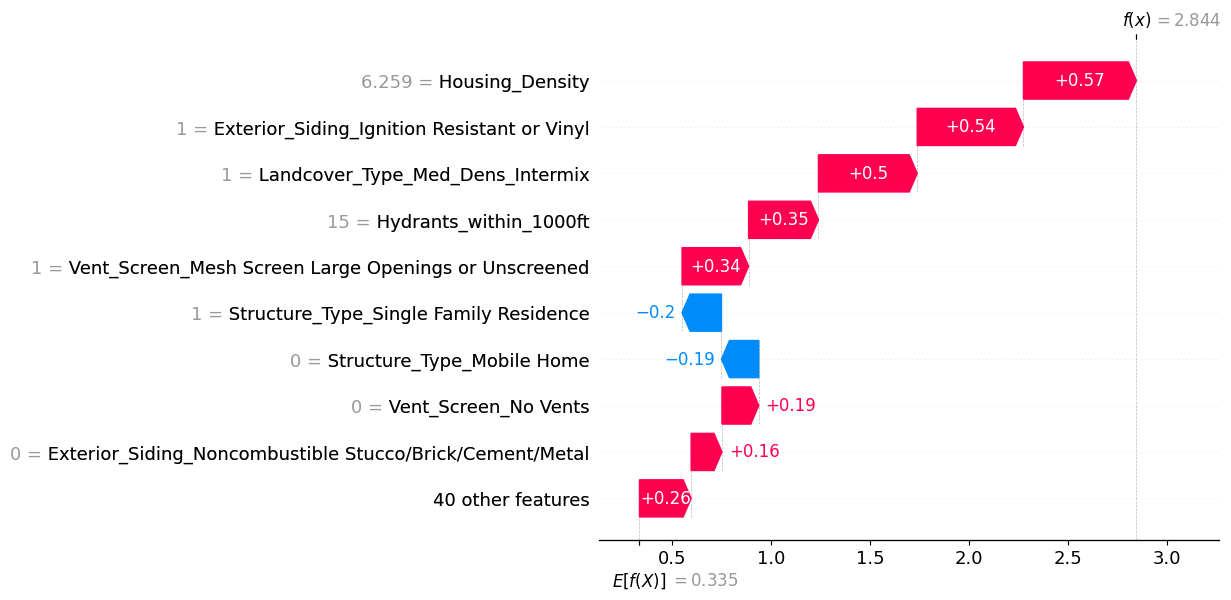

In [94]:
shap.plots.waterfall(shap_values[10])

### 2.3 Random Forest Classifier

First conduct hyperparameter tuning using TPOT (a genetic algorithm auto machine learning framework - http://epistasislab.github.io/tpot/)

In [9]:
# AutoML hyperparameter tuning, somewhat arbitrary
classifier_config_dict = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf':  range(1, 21),
        'bootstrap': [True, False],
        'class_weight': ['balanced']  # Use balanced class weights,
    }
}

# Create TPOT object
# Number of generations and population size could be larger
# but it either breaks the computer or takes 200 years
tpot_auto = TPOTClassifier(generations=5,
                           population_size=10,
                           verbosity=2,
                           n_jobs=-1,
                           cv=10,
                           config_dict=classifier_config_dict,
                           scoring='balanced_accuracy',
                           random_state=7)

# Fit the model
tpot_auto.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8870164948918541

Generation 2 - Current best internal CV score: 0.8870164948918541

Generation 3 - Current best internal CV score: 0.8870164948918541

Generation 4 - Current best internal CV score: 0.8874455653553625

Generation 5 - Current best internal CV score: 0.888541552905268

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), bootstrap=True, class_weight=balanced, criterion=entropy, max_features=0.25, min_samples_leaf=5, min_samples_split=2, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'bootstrap': [True,
                                                                                      False],
                                                                        'class_weight': ['balanced'],
                                                                        'criterion': ['gini',
                                                                                      'entropy'],
                                                                        'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                                                        'min_samples_leaf': range(1, 21),
                                                                        'min_samples_split': range(2, 21),
                                                                        'n_estimato

Calculate classification metrics on the most optimal pipeline

In [10]:
y_pred = tpot_auto.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(f"Model accuracy on test data is {np.round(cr['accuracy'] * 100, 2)}%")
print(f"Model weighted avg precision on test data is {np.round(cr['weighted avg']['precision'], 2)}")
print(f"Model weighted avg recall on test data is {np.round(cr['weighted avg']['recall'], 2)}")

# Export pipeline in case I lose the parameters
tpot_auto.export('tpot_optimal_pipeline.py')

Model accuracy on test data is 89.93%
Model weighted avg precision on test data is 0.9
Model weighted avg recall on test data is 0.9


Using the optimized parameters, build a RandomForestClassifier from scratch

In [95]:
rfc = RandomForestClassifier(bootstrap=True, 
                             class_weight="balanced", 
                             criterion="entropy", 
                             max_features=0.25, 
                             min_samples_leaf=5, 
                             min_samples_split=2, 
                             n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features=0.25, min_samples_leaf=5)

Perform 10-fold cross validation using stratified k-folds which preserve the percentage of samples for each class across the folds

In [96]:
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(rfc, X_train, y_train, cv=kfold)

Display the model accuracy and confusion matrix for the initial fit

Mean accuracy across the folds is 88.82%


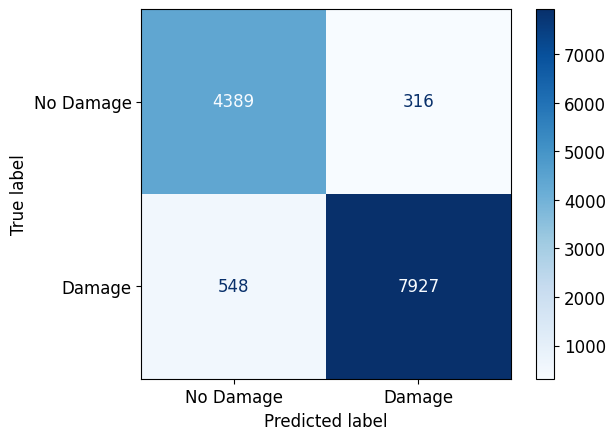

In [97]:
# Mean accuracy from CV and contingency table for training data
print(f"Mean accuracy across the folds is {np.round(np.mean(results) * 100, 2)}%")

# Confusion matrix
plot_confusion_matrix(rfc, X_train, y_train, display_labels=["No Damage", "Damage"], cmap='Blues')  
plt.show() 

Similar to before, we evaluate the classification threshold and find the best metrics where the threshold is around 0.4 to 0.5

In [98]:
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    preds = np.where(rfc.predict_proba(X_test)[:,1] > i, 1, 0)

    model_metrics = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                       precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"])
    print(model_metrics)


******** For i = 0.1 ******
                      0
accuracy       0.793993
recall         0.993931
precision      0.761717
roc_auc_score  0.708404

******** For i = 0.2 ******
                      0
accuracy       0.857706
recall         0.982726
precision      0.829720
roc_auc_score  0.804188

******** For i = 0.3 ******
                      0
accuracy       0.886226
recall         0.959851
precision      0.876759
roc_auc_score  0.854709

******** For i = 0.4 ******
                      0
accuracy       0.894114
recall         0.936041
precision      0.904375
roc_auc_score  0.876166

******** For i = 0.5 ******
                      0
accuracy       0.897755
recall         0.906162
precision      0.934521
roc_auc_score  0.894156

******** For i = 0.6 ******
                      0
accuracy       0.883192
recall         0.865079
precision      0.950744
roc_auc_score  0.890945

******** For i = 0.7 ******
                      0
accuracy       0.855583
recall         0.809057
preci

Predict on 20% of data and report classification metrics

In [99]:
# Prediction and classification report
y_pred = rfc.predict(X_test)
cr = classification_report(y_test, y_pred, output_dict=True)
print(f"Model accuracy on test data is {np.round(cr['accuracy'] * 100, 2)}%")
print(f"Model weighted avg precision on test data is {np.round(cr['weighted avg']['precision'], 2)}")
print(f"Model weighted avg recall on test data is {np.round(cr['weighted avg']['recall'], 2)}")

Model accuracy on test data is 89.78%
Model weighted avg precision on test data is 0.9
Model weighted avg recall on test data is 0.9


Plot confusion matrix of test data

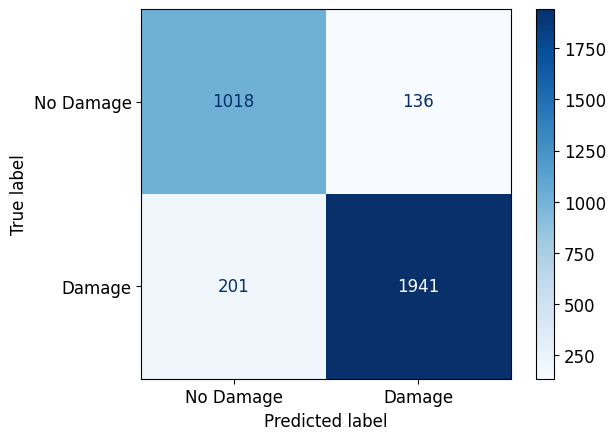

In [100]:
plot_confusion_matrix(rfc, X_test, y_test, display_labels=["No Damage", "Damage"], cmap='Blues')  
plt.show()  

Plot ROC curve

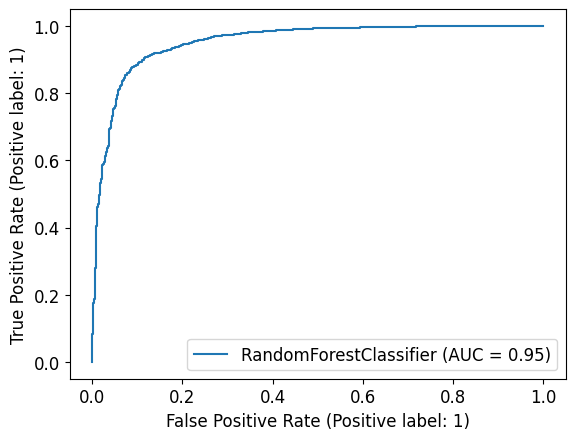

In [101]:
plot_roc_curve(rfc, X_test, y_test)

Mean feature importance using SHAP

In [102]:
# There is a bug with certain installations where the c extension 'cext' does not build
# This extension is used for explaining tree type algorithms 
# Trying my work machine, home machine, and a docker image with several versions all failed
# SHAP is only version 0.39, so hopefully this library can be useful in the future when stable

# shap_values = shap.TreeExplainer(rfc).shap_values(X_train)

Generate a graph of feature importances instead of using SHAP

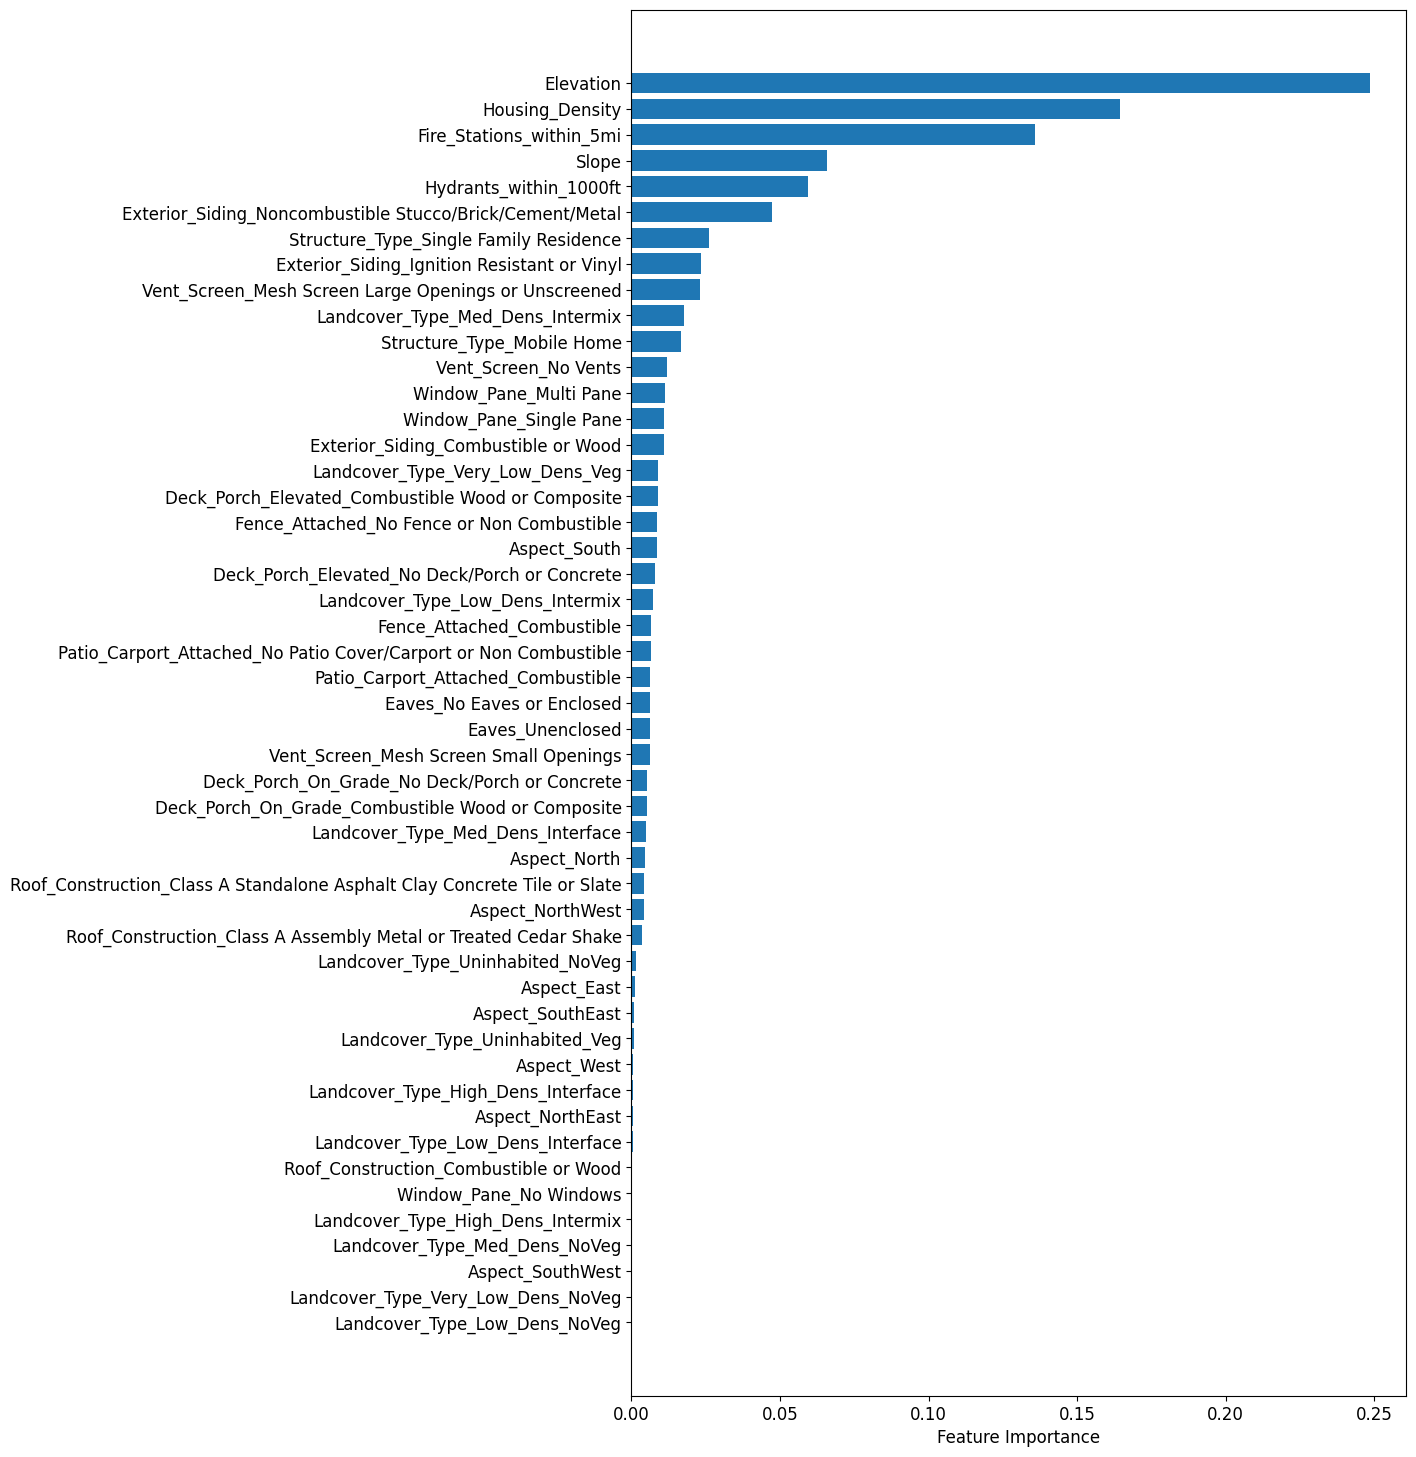

In [103]:
# Extract feature importances
importance = rfc.feature_importances_

# Join to appropriate labels
imp_vals = {X_train.columns[i]: v for i,v in enumerate(importance)}

# Sort the dictionary 
imp_vals = {k: v for k, v in sorted(imp_vals.items(), key=lambda item: item[1])}

# Plot feature importances
plt.rcdefaults()
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
fig.set_size_inches(10, 18)
igsize=(8, 6)
ax.barh(list(imp_vals.keys()), imp_vals.values())
ax.set_xlabel('Feature Importance')
plt.show()